In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import calendar
#import prophet
from datetime import datetime

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

plt.rcParams["figure.figsize"] = (10,8)

In [56]:
df = pd.read_csv("data/bikes.csv", index_col = 0 )

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(2)
memory usage: 97.0+ KB


In [58]:
df.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
276,277,04-10-2018,winter,0,10,0,2,1,1,19.850847,23.64290,71.0000,13.792218,486,3970,4456
273,274,01-10-2018,winter,0,10,0,6,0,2,16.810000,20.64315,75.3750,19.583832,480,1949,2429
147,148,28-05-2018,summer,0,5,0,6,0,1,26.889153,30.61895,72.9583,15.416164,2001,2757,4758
387,388,23-01-2019,spring,1,1,0,1,1,2,8.951653,12.15290,91.1250,7.417436,145,2287,2432
659,660,22-10-2019,winter,1,10,0,1,1,1,19.987500,24.14710,56.8333,5.459381,830,6228,7058


- 1. En la columna yr, el 0 hace referencia a 2018 y el 1 2019 ---> cambiar a 2018 y 2019
- 2. Revisar estaciones segun meses - DONE  - día específico de la semana 😒
- 3. Los dias de la semana pasarlos a str (texto)
- 4. Redondear temperaturas
- 5. Cambiar dteday a tipo daytime DONE 
- 6. Comprobar festivos - columna holiday - 16 días
- 7. Los dias de la semana no corresponden con los que debieran ser 🤦‍♀️🤦‍♀️
- 8. librería prophet - solo festivos nacionales 👁️ hacer otro entorno
- 9. Librería calendar - dia de la semana DONE.
- 10. Chequear funcion seasons 

Weathersit :
- 1: Sol y nubes
- 2: Niebla - nublado
- 3: Regulinchi
- 4: Tiempo chungo

In [59]:
df.duplicated().sum()

0

In [60]:
df.shape

(730, 16)

__________
Reasignamos columna season

In [61]:
#Cambiar columna 'dteday' a datatime

df.dteday =pd.to_datetime(df.dteday, dayfirst=True)

In [62]:
primavera = df[df['season']=='spring'] #Primavera 20 marzo - 21 junio
primavera['mnth'].unique()

array([ 1,  2,  3, 12])

In [63]:
invierno = df[df['season']=='winter'] # Invierno 21 de diciembre - 20 de marzo
invierno['mnth'].unique()

array([ 9, 10, 11, 12])

In [64]:
#Verano 21 junio - 23 septiembre 
verano = df[df['season']=='summer'] 
verano['mnth'].unique()

array([3, 4, 5, 6])

In [65]:
#Otoño 23 septiembre - 21 de diciembre
otoño = df[df['season']=='autumn'] 
otoño['mnth'].unique()

array([6, 7, 8, 9])

In [66]:
mapa_estaciones ={"spring": "winter", "winter": "autumn", "summer":"spring", "autumn":"summer"}

In [67]:
df["season"] = df["season"].map(mapa_estaciones)

In [68]:
#Primavera 21 marzo - 20 junio
#Verano 21 junio - 22 septiembre 
#Otoño 23 septiembre - 20 de diciembre
#Invierno 21 de diciembre - 20 de marzo

_________________

Ajustamos los días de la semana

In [69]:
def dia_semana(col):
    return col.isoweekday()

In [70]:
df["weekday"]= df["dteday"].apply(dia_semana)

__________


In [ ]:
festivos_18 = ["2018-01-01","2018-01-16", "2018-02-13", "2018-02-20", "2018-03-31", "2018-05-29", "2018-07-04", "2018-07-05", "2018-07-28" , "2018-09-04", "2018-10-23", "2018-10-24", "2018-12-24", "2018-12-25", "2018-12-31"]
festivos_19 = ["2019-01-01","2019-01-16", "2019-02-13", "2019-02-20", "2019-03-31", "2019-05-29", "2019-07-04", "2019-07-05", "2019-07-28" , "2019-09-04", "2019-10-23", "2019-10-24", "2019-12-24", "2019-12-25", "2019-12-31"]

In [72]:
df.workingday.value_counts()

1    499
0    231
Name: workingday, dtype: int64

In [73]:
df.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [74]:
festivos = df[df['holiday']== 1]

In [75]:
festivos.head(21)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
16,17,2018-01-17,winter,0,1,1,3,0,2,7.209153,8.83855,53.7500,12.999139,117,883,1000
51,52,2018-02-21,winter,0,2,1,3,0,2,12.436653,14.20375,60.5000,20.625682,195,912,1107
104,105,2018-04-15,spring,0,4,1,7,0,1,18.313347,22.09565,67.1250,15.167125,642,2484,3126
149,150,2018-05-30,spring,0,5,1,3,0,1,30.066653,33.55460,68.5000,8.792075,1549,2549,4098
184,185,2018-07-04,summer,0,7,1,3,0,2,29.793347,33.27085,63.7917,5.459106,3065,2978,6043
247,248,2018-09-05,summer,0,9,1,3,0,2,27.606653,31.28230,79.0417,14.250632,1236,2115,3351
282,283,2018-10-10,autumn,0,10,1,3,0,1,23.404153,27.14625,73.3750,2.834381,1514,3603,5117
314,315,2018-11-11,autumn,0,11,1,7,0,1,13.290847,15.34085,44.6250,21.083225,440,2928,3368
327,328,2018-11-24,autumn,0,11,1,6,0,1,15.306653,18.62355,54.9167,11.209368,560,935,1495
359,360,2018-12-26,winter,0,12,1,3,0,1,13.191299,15.77675,50.6957,16.044155,430,887,1317


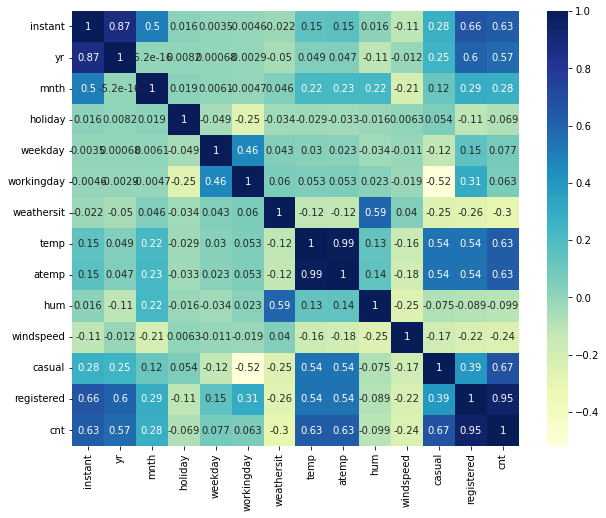

In [76]:

sns.heatmap(df.corr(), 
            cmap = "YlGnBu", 
           annot = True);

In [77]:
df.tail(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
720,721,2019-12-22,winter,1,12,0,7,0,1,10.899153,11.80565,44.1250,27.292182,205,1544,1749
721,722,2019-12-23,winter,1,12,0,1,0,1,10.079153,12.97355,51.5417,8.916561,408,1379,1787
722,723,2019-12-24,winter,1,12,0,2,1,2,9.483464,12.94500,79.1304,5.174437,174,746,920
723,724,2019-12-25,winter,1,12,1,3,0,2,11.943464,14.72325,73.4783,11.304642,440,573,1013
724,725,2019-12-26,winter,1,12,0,4,1,3,9.976653,11.01665,82.3333,21.208582,9,432,441
725,726,2019-12-27,winter,1,12,0,5,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,2019-12-28,winter,1,12,0,6,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,2019-12-29,winter,1,12,0,7,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,2019-12-30,winter,1,12,0,1,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,2019-12-31,winter,1,12,0,2,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    object        
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [79]:
df.sample(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
233,234,2018-08-22,summer,0,8,0,3,1,1,28.358347,31.91270,47.0000,18.542250,833,3925,4758
685,686,2019-11-17,autumn,1,11,0,7,0,1,13.325000,16.31915,54.5417,12.041843,1313,4316,5629
435,436,2019-03-12,winter,1,3,0,2,1,1,19.133347,22.97960,48.9167,13.916771,838,4460,5298
240,241,2018-08-29,summer,0,8,0,3,1,1,26.103347,30.39790,55.4583,10.708275,729,3905,4634
324,325,2018-11-21,autumn,0,11,0,3,1,3,18.347500,22.25310,91.0000,9.249618,220,2545,2765


In [80]:
# Identificar los dias exactos por season 
festivos =[]

